In [1]:
#Step 0: Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.inspection import permutation_importance
from scipy.stats import boxcox


- **Source**: Hill, LaPan, Li and Haney (2007). Impact of image segmentation on high-content screening data quality for SK-BR-3 cells, BMC Bioinformatics, Vol. 8, pg. 340

In [2]:
#Step 1: Load data
url = '/content/skbr_cells.csv'
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 61 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Cell                     2019 non-null   int64  
 1   Case                     2019 non-null   object 
 2   Class                    2019 non-null   object 
 3   AngleCh1                 2019 non-null   float64
 4   AreaCh1                  2019 non-null   int64  
 5   AvgIntenCh1              2019 non-null   float64
 6   AvgIntenCh2              2019 non-null   float64
 7   AvgIntenCh3              2019 non-null   float64
 8   AvgIntenCh4              2019 non-null   float64
 9   ConvexHullAreaRatioCh1   2019 non-null   float64
 10  ConvexHullPerimRatioCh1  2019 non-null   float64
 11  DiffIntenDensityCh1      2019 non-null   float64
 12  DiffIntenDensityCh3      2019 non-null   float64
 13  DiffIntenDensityCh4      2019 non-null   float64
 14  EntropyIntenCh1         

In [3]:
df_raw.sample(10, random_state=2025)

,Cell,Case,Class,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,ConvexHullAreaRatioCh1,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
1526,208336841,Train,WS,148.157960,308,118.761905,197.187075,70.027211,112.697279,1.065898,...,34916,57680,20588,33133,48.976509,156.199809,104.811623,18.749445,460,188
1551,208396157,Test,PS,10.346789,242,58.722944,6.909091,77.497835,3.194805,1.231397,...,13565,1366,17902,738,68.858858,171.501111,3.662276,15.203546,201,399
552,208312454,Test,PS,109.824389,160,61.143791,4.712418,147.366013,34.052288,1.167683,...,9355,569,22547,5210,37.426777,91.057243,46.012188,12.061842,216,163
1956,208935209,Train,PS,164.907580,153,25.719178,115.417808,26.904110,86.863014,1.179153,...,3755,16706,3928,12682,16.221389,26.463293,58.400909,11.939754,269,107
135,208406905,Test,WS,143.244805,246,23.834043,246.068085,10.506383,43.165957,1.097487,...,5601,57592,2469,10144,17.349784,25.911859,66.686581,15.969757,494,64
571,208405358,Test,PS,111.650507,293,37.342857,4.432143,83.782143,54.010714,1.413115,...,10456,962,23459,15123,21.287747,43.671653,69.855283,9.123565,114,236
325,208410525,Test,WS,83.976225,316,39.970199,140.996689,47.619205,66.612583,1.089897,...,12071,42280,14381,20117,28.215745,47.378328,65.185463,13.399715,275,84
723,208406924,Test,PS,108.271419,563,20.990706,62.881041,25.752788,13.386617,1.595038,...,11293,33293,13855,7202,17.458658,33.273512,28.350160,27.449929,387,152
1056,208396138,Train,PS,19.550427,412,214.098985,328.918782,238.106599,446.873096,1.136391,...,84355,129201,93814,176068,164.607880,321.653823,376.531983,22.847778,111,303
411,208397497,Train,PS,86.122381,310,95.827703,136.952703,171.847973,568.989865,1.124491,...,28365,40243,50867,168421,54.252295,137.681847,361.835294,16.429758,210,307


In [4]:
#Step 2: Preprocessing
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower()
df_baking = df_baking[['perimch1', 'eqsphereareach1', 'entropyintench1', 'class']]
df_baking = df_baking.drop_duplicates()
df_baking['class'] = df_baking['class'].astype('category')
#df_baking['eqsphereareach1_inv'] = 1/(df_baking['eqsphereareach1']**2)
#df_baking['perimch1_inv'] = 1/df_baking['perimch1']
#df_baking = df_baking.drop(columns=['perimch1','eqsphereareach1'])
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   perimch1         2019 non-null   float64 
 1   eqsphereareach1  2019 non-null   float64 
 2   entropyintench1  2019 non-null   float64 
 3   class            2019 non-null   category
dtypes: category(1), float64(3)
memory usage: 49.5 KB


In [5]:
#Step3: EDA
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=2025)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train.shape, df_test.shape

((1615, 4), (404, 4))

In [6]:
'''_, lambda_perimch1 = boxcox(df_train['perimch1'])
_, lambda_esphere1 = boxcox(df_train['eqsphereareach1'])
print(f'Lambda perimch1: {lambda_perimch1}, Lambda esphere area: {lambda_esphere1}')'''

"_, lambda_perimch1 = boxcox(df_train['perimch1'])\n_, lambda_esphere1 = boxcox(df_train['eqsphereareach1'])\nprint(f'Lambda perimch1: {lambda_perimch1}, Lambda esphere area: {lambda_esphere1}')"

In [7]:
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
perimch1,1615.0,89.878828,41.682705,47.489176,64.015648,77.149514,99.197799,459.765378
eqsphereareach1,1615.0,1278.413006,841.824173,603.755102,775.657596,1002.065760,1454.882086,8746.063492
entropyintench1,1615.0,6.574064,0.746037,4.707829,6.022178,6.573556,7.031053,9.475700


,count,unique,top,freq
class,1615,2,PS,1040


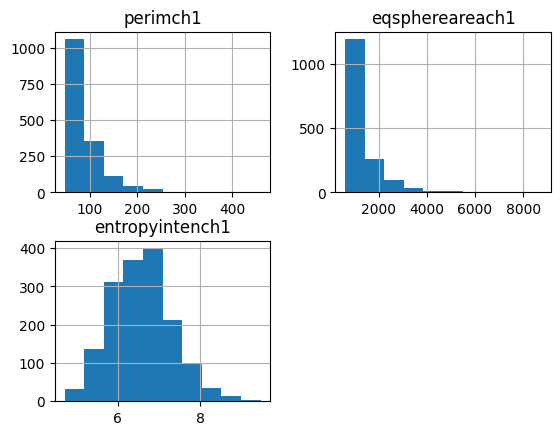

In [8]:
df_train.hist()
plt.show()

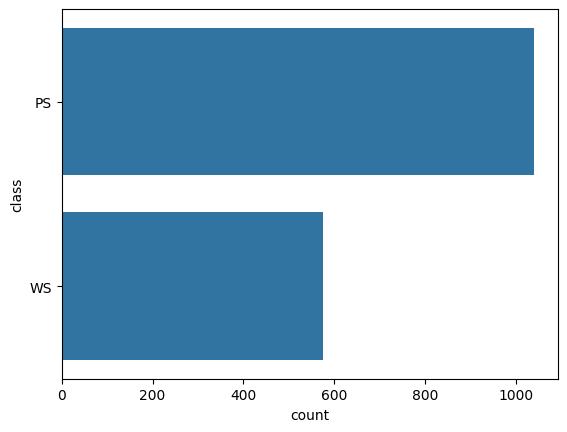

In [9]:
sns.countplot(data=df_train, y='class')
plt.show()

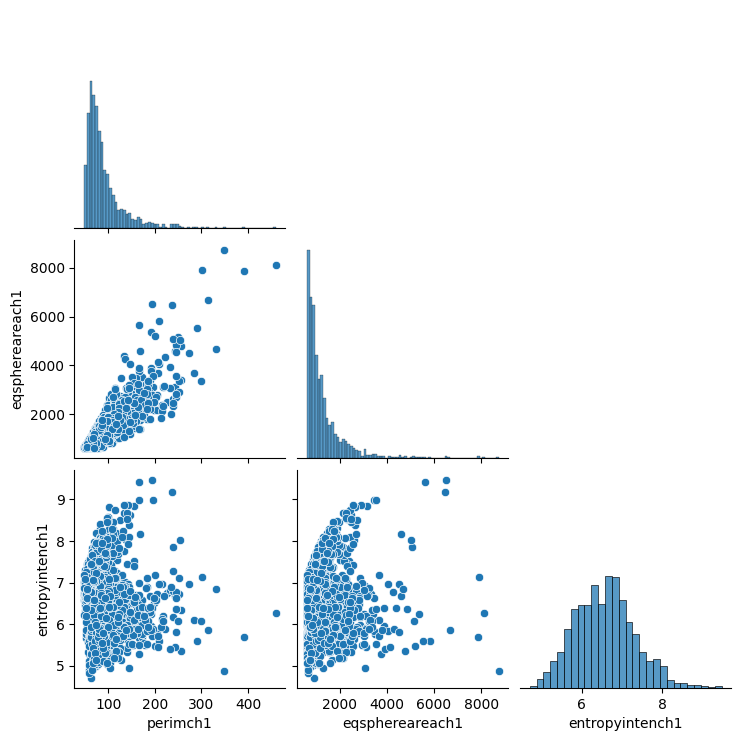

In [10]:
sns.pairplot(df_train, corner=True)
plt.show()

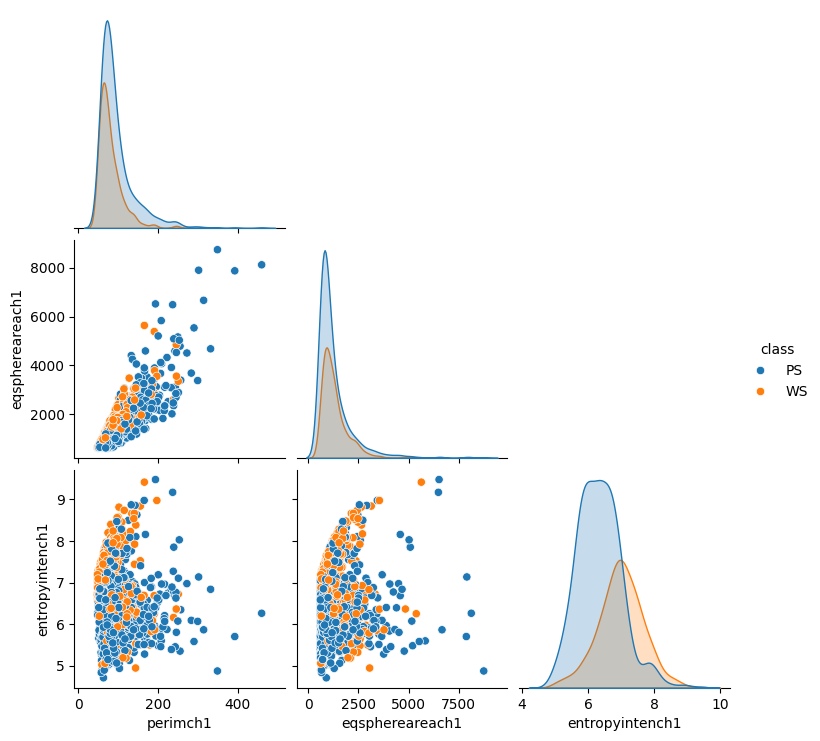

In [11]:
sns.pairplot(df_train, hue='class', corner=True)
plt.show()

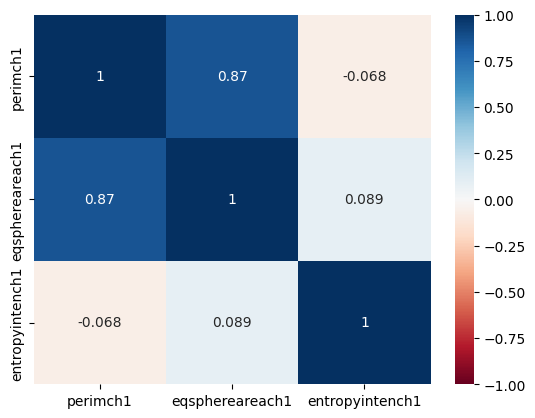

In [12]:
sns.heatmap(df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()


In [13]:
#Step 4: ML
X_train = df_train.drop(columns='class')
y_train = df_train['class']

X_test = df_test.drop(columns='class')
y_test = df_test['class']

In [14]:
yescols = X_train[['perimch1','eqsphereareach1']].columns
nocols = X_train[['entropyintench1']].columns

box_transformer = Pipeline([
    ('powertrans', PowerTransformer()),
    ('scaler', StandardScaler())
])

nobox_transformer = Pipeline([
    ('scaler', StandardScaler())
])

processor = ColumnTransformer([
    ('yes', box_transformer, yescols),
    ('no', nobox_transformer, nocols)
])

In [15]:
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

In [16]:
clf_tree = Pipeline([
    ('proc', processor),
    ('tree', DecisionTreeClassifier(class_weight='balanced', random_state=2025))
])

clf_tree.fit(X_train, y_train_enc)

Pipeline(steps=[('proc',
                 ColumnTransformer(transformers=[('yes',
                                                  Pipeline(steps=[('powertrans',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['perimch1', 'eqsphereareach1'], dtype='object')),
                                                 ('no',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['entropyintench1'], dtype='object'))])),
                ('tree',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=2025))])

In [17]:
y_hat = clf_tree.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test_enc, y_hat):.2f}')

Accuracy: 0.71


In [18]:
clf_tree_cv = GridSearchCV(
    estimator = clf_tree,
    param_grid = {
        'tree__max_depth':[2,3,4,5,6,7], #6
        'tree__min_samples_split':[2,4,6], #3
    },
    cv = 5
)
clf_tree_cv.fit(X_train, y_train_enc)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('proc',
                                        ColumnTransformer(transformers=[('yes',
                                                                         Pipeline(steps=[('powertrans',
                                                                                          PowerTransformer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['perimch1', 'eqsphereareach1'], dtype='object')),
                                                                        ('no',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['entropyintench1'], dtype='object'))])),
                                       ('tree',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=2025))]),
             param_grid={'tree__max_depth': [2, 3, 4, 5, 6, 7],
                         'tree__min_samples_split': [2, 4, 6]})

In [19]:
y_hat = clf_tree_cv.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test_enc, y_hat):.2f}')

Accuracy: 0.73


In [20]:
clf_gb = Pipeline([
    ('proc', processor),
    ('gb', GradientBoostingClassifier(random_state=2025))

])
clf_gb.fit(X_train, y_train_enc)

Pipeline(steps=[('proc',
                 ColumnTransformer(transformers=[('yes',
                                                  Pipeline(steps=[('powertrans',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['perimch1', 'eqsphereareach1'], dtype='object')),
                                                 ('no',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['entropyintench1'], dtype='object'))])),
                ('gb', GradientBoostingClassifier(random_state=2025))])

In [21]:
y_hat = clf_gb.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test_enc, y_hat):.2f}')

Accuracy: 0.79


In [22]:
clf_gb_cv = GridSearchCV(
    estimator = clf_gb,
    param_grid = {
        'gb__max_depth':[2,3,4,5,6,7], #6
        'gb__min_samples_split':[2,4,6], #3
        'gb__n_estimators':[50,100,150,200], #4
        'gb__learning_rate':[0.1,1,10,100] #5
    },

    cv = 5
)

clf_gb_cv.fit(X_train, y_train_enc)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('proc',
                                        ColumnTransformer(transformers=[('yes',
                                                                         Pipeline(steps=[('powertrans',
                                                                                          PowerTransformer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['perimch1', 'eqsphereareach1'], dtype='object')),
                                                                        ('no',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['entropyintench1'], dtype='object'))])),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=2025))]),
             param_grid={'gb__learning_rate': [0.1, 1, 10, 100],
                         'gb__max_depth': [2, 3, 4, 5, 6, 7],
                         'gb__min_samples_split': [2, 4, 6],
                         'gb__n_estimators': [50, 100, 150, 200]})

In [23]:
y_hat = clf_gb_cv.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test_enc, y_hat):.2f}')

Accuracy: 0.78
